In [1]:
! pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp "/content/drive/MyDrive/Kaggle API/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# recupérer les données à partir de kaggle
! kaggle datasets download "jessicali9530/celeba-dataset"


100% 1.33G/1.33G [00:12<00:00, 133MB/s]
100% 1.33G/1.33G [00:12<00:00, 111MB/s]


In [5]:
import multiprocessing as mp
mp.cpu_count()

2

In [6]:
! unzip "/content/celeba-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

# Import des bibliothéques necessaire

In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import f1_score,precision_score
from PIL import Image
from torchvision.transforms import transforms 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from pathlib import Path
import math
import copy
import pandas as pd

# Import des meta-données et des images

In [8]:
image_path='./img_align_celeba/img_align_celeba'
df_attr=pd.read_csv('./list_attr_celeba.csv')
df_landmarks=pd.read_csv('./list_landmarks_align_celeba.csv')
df_bbox=pd.read_csv('./list_bbox_celeba.csv')
df_attr.head()
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [9]:
df_attr.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

# Creation du Data-Loader 

In [10]:
# Class to get data in specific format and preprocessing.
class CelebDataset(Dataset):
    def __init__(self,df_1,image_path,transform=None,mode='train'):
        super().__init__()
        self.attr=df_1.drop(['image_id'],axis=1)
        self.path=image_path
        self.image_id=df_1['image_id']
        self.transform=transform
        self.mode=mode
    def __len__(self):
        return self.image_id.shape[0]
    def __getitem__(self,idx:int):
        image_name=self.image_id.iloc[idx]
        image=Image.open(os.path.join(image_path,image_name))
        attributes=np.asarray(self.attr.iloc[idx].T,dtype=np.float32)
        if self.transform:
            image=self.transform(image)
        return image,attributes    

# Deviser en train test et validation 

In [11]:
df_attr.shape

(202599, 41)

In [12]:
df_attr.head(2)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


> - Nous avons dans notre base de données 202599 images et 40 attributs

In [13]:
from sklearn.model_selection import train_test_split
train_df,test=train_test_split(df_attr,test_size=0.05,shuffle=True,random_state=212)
valid_df,test_df=train_test_split(test,test_size=0.05,random_state=212)
train_df.shape,valid_df.shape,test_df.shape


((192469, 41), (9623, 41), (507, 41))

> - Les dimension de la train data est 182339 images et , 40 caratéristiques. soit 90% des images

> - Les dimension de la validation data est 10130 images et , 40 caratéristiques. soit 5% des images

> - Les dimension du test data est 10130 images et , 40 caratéristiques. soit 5% des images

# Preprocess des données

In [14]:
# Appliquer l'augmentation des données et différents types de transformations sur les données du train.

train_transform=transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(p=0.1),transforms.ColorJitter(
                                        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2
                                        ),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5063, 0.4258, 0.3832],
                                                         std=[0.2644, 0.2436, 0.2397])])

# Appliquer l'augmentation des données et différents types de transformations sur les données du validation

valid_transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5063, 0.4258, 0.3832],
                                                   std=[0.2644, 0.2436, 0.2397])])

# Création de l'objet Dataset et le DataLoader pour les ensembles de train et de validation. 

In [15]:
train_df.head(2)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
26856,026857.jpg,0,1,1,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
199653,199654.jpg,0,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1


In [16]:
train_data=CelebDataset(train_df,image_path,train_transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
valid_data=CelebDataset(valid_df,image_path,valid_transform)
valid_loader=DataLoader(valid_data,batch_size=64,num_workers=2)

# Visualisation d'une échantillon 

In [17]:
# fonction pour visualiser le dataset
def imshow(images,attr,idx:int):
    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()


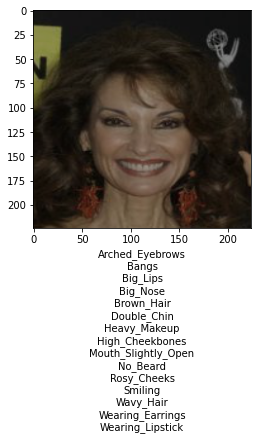

In [18]:
# visualisation
images,attr=next(iter(train_loader))
imshow(images,attr,0)

# Creation du modèle

## Conceptionde la Classe pour une seul couche (Layer).

In [19]:
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
        super(Layer,self).__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
        self.bn=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        nn.init.xavier_uniform_(self.conv.weight)
    def forward(self,Input):
        output=self.conv(Input)
        output=self.bn(output)
        output=self.relu(output)
        return output

## Conception du modèle complet

In [20]:
class CelebModel(nn.Module):
    def __init__(self,num_classes=40):
        super(CelebModel,self).__init__()
        
        self.unit1=Layer(in_ch=3,out_ch=32)        
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
        self.drop2=nn.Dropout(0.5)   
        
        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        
        self.pool5=nn.AvgPool2d(kernel_size=2)
        
        self.drop3=nn.Dropout(0.5)
        
        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)
        
        self.fc=nn.Linear(in_features=512,out_features=num_classes)
        
    def forward(self,Input):
        
        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)
        
        return output

# Preparation de l'environment

In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creation de l'obejt modèle, de la fonction de perte (Loss function), de l'optimiseur, et du scheduler

In [22]:
# Creating Model Object,loss function,optimizer and scheduler
model=CelebModel().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
scheduler=optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000001, max_lr=1,mode='exp_range')

# Phase d'apprentissage 

In [23]:
# Création d'un checkpoint pour sauvegarder le modèle
def Save_model(model,cur_acc,best_acc,filename):
    if cur_acc>best_acc:
        best_acc=cur_acc
        best_model=copy.deepcopy(model)
        torch.save(best_model.state_dict(),filename)
    return best_acc


In [24]:
# Creation de la validation loop 
def val_model():
    model.eval()
    epoch_loss=0
    acc=0
    with torch.no_grad():
        val_pred=[]
        val_lbl=[]
        for images,attr in valid_loader:
            
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            val_lbl.append(attr.detach().cpu())
            
            val_pred.append(prediction.detach().cpu()) 
            
        epoch_loss/=len(valid_data)
        
        acc=f1_score(torch.cat(val_lbl,dim=0).numpy(),torch.cat(val_pred,dim=0).numpy(),average='samples')
        
        return epoch_loss,acc    


In [25]:
# Creation du Training loop 

def train_model(num_epochs):
    train_loss=[]
    best_acc=0.0
    for i in range(num_epochs):
        epoch_loss=0
        acc=0
        j=0
        epoch_pred=[]
        epoch_lbl=[]
        model.train()
        for images,attr in train_loader:
            j+=1 
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            optimizer.zero_grad()
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            loss.backward()
            
            optimizer.step()
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            epoch_lbl.append(attr.detach().cpu())
            
            epoch_pred.append(prediction.detach().cpu()) 
            
            torch.cuda.empty_cache()
            
            if (j+1)%100==0:
                print(f'Loss #{(j+1)//100}:{loss.item()}')
            
            scheduler.step()
            
        epoch_loss/=len(train_data)
        
        acc=f1_score(torch.cat(epoch_lbl,dim=0).numpy(),torch.cat(epoch_pred,dim=0).numpy(),average='samples')
        
        train_loss.append(epoch_loss)
        
        val_loss,val_acc=val_model()
        
        best_acc=Save_model(model,val_acc,best_acc,'/content/drive/MyDrive/HETIC PFA/Models/face_attributes_model.pth')   # save model
        
        print(f'Epoch : {i+1} , Training loss:{epoch_loss} , Training acc_score:{acc} , Validation loss:{val_loss} , Validation _score:{val_acc}')


In [26]:
# # Training
# %%time
num_epochs=10
if __name__=='__main__':
  train_model(num_epochs)

Loss #1:0.4026198983192444
Loss #2:0.3393418788909912
Loss #3:0.33667391538619995
Loss #4:0.3033483922481537
Loss #5:0.3173274099826813


KeyboardInterrupt: ignored

In [ ]:
#! cp "/content/model.pth" "/content/drive/MyDrive/HETIC PFA/Models/facial_attributes_model.pth"

In [ ]:
!pwd

In [ ]:
os.chdir("/content/drive/MyDrive/HETIC PFA")

In [ ]:

model.load_state_dict(torch.load("./Models/face_attributes_model.pth", map_location='cpu'))
model.eval()

In [ ]:
for params in model.parameters():
  print(params.shape)

In [ ]:
# Create Dataset Object and DataLoader for train and validation set
test_data=CelebDataset(test_df,image_path,valid_transform)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False,num_workers=4)
# Function to predict Labels
def Predict(images,model,idx:int):
    pred=model(images)
    images=images.cpu().numpy().transpose((0,2,3,1))
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2, 1)
    plt.imshow(images[idx])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    attr=torch.round(torch.sigmoid(pred)).cpu().detach()
    prd=torch.sigmoid(pred[idx]).cpu().detach().numpy()
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    pred_list=[p for p,a in list(zip(prd,att)) if a==1]
    plt.subplot(1,2,2)
    plt.barh(labels,pred_list)
    plt.show()
    return labels

In [ ]:
os.chdir("/content/")

In [ ]:
# Testing Model
images,attr=next(iter(test_loader))

# Getting actual labels
labels=df_attr.columns.tolist()
labels=labels[1:]
act_labels=[l for l,a in zip(labels,attr[20].numpy()) if a==1]


# Making prediction on test dataset
pred_labels=Predict(images,model,12)


print('Labels:',act_labels)
print('Predictions:',pred_labels)

In [ ]:
test_loader.dataset[0][0].shape